# Notebook Description

This notebook will focus on creating a Department Classifier, based on cart input data.

The investigation will begin by predicting Department affinity, assuming that the cart is _empty_. Later, 

# Initialize

## Imports

In [58]:
import math
import random
import pandas as pd
import numpy as np
import itertools as IT

import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix 
from sklearn.model_selection import train_test_split

# Classification Models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load Subset of Data into Pandas Dataframe

In [3]:
df_aisle_index = pd.read_csv('../data/instacart-market-basket-analysis/aisles.csv')
print(df_aisle_index.shape)
df_dept_index = pd.read_csv('../data/instacart-market-basket-analysis/departments.csv')
print(df_dept_index.shape)
df_prod_index = pd.read_csv('../data/instacart-market-basket-analysis/products.csv')
print(df_prod_index.shape)

(134, 2)
(21, 2)
(49688, 4)


## Load Order Log, and Order Products

In [4]:
# define subset of data
# Take a sample of the 10,000 users represented in the data

# randomized version
# np.random.seed(4444)
# user_sample_list = np.random.choice(a=range(1,10000,1), size=300, replace=False)

user_subset = range(1,501, 1)

print('generated user subset of size: ', len(user_subset))

generated user subset of size:  500


In [5]:
# Create a generalized mask that filters rows
# which are not applicable to the sampled users.
#
# masked_df = pd.DataFrame(
#     columns=['user_id']
# )
#
# user_mask = ([
#     (masked_df.user_id.isin(user_sample_list))
# ])

df_orders_log = pd.DataFrame(
    columns=['order_id','user_id','eval_set','order_number',
             'order_dow','order_hour_of_day','days_since_prior_order']
)

# import the orders csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset


def valid_user(chunks):
    for chunk in chunks:
        mask = chunk.user_id.isin(user_subset)
        yield chunk.loc[mask]

In [6]:
# read in orders
filename = '../data/instacart-market-basket-analysis/orders.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_orders_log = pd.concat(valid_user(chunks))

In [7]:
print(sys.getsizeof(df_orders_log)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/orders.csv').st_size//1000000,'MB')

0.960604 MB vs  108 MB


In [8]:
# compile a list of unique orders that originate from our user sample

orders_subset = df_orders_log.order_id.unique()
print(orders_subset.shape)

def valid_order(chunks):
    for chunk in chunks:
        mask = chunk.order_id.isin(orders_subset)
        yield chunk.loc[mask]

(8142,)


In [9]:
df_order_prods__prior = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order','reordered']
)

# import the prior/train_products csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset



# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__prior.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__prior = pd.concat(valid_order(chunks))

In [10]:
print(sys.getsizeof(df_order_prods__prior)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/order_products__prior.csv').st_size//1000000,'MB')
print(df_order_prods__prior.shape)

3.097032 MB vs  577 MB
(77425, 4)


In [11]:
df_order_prods__train = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order']
)

# import the prior/train_products csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__train.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__train = pd.concat(valid_order(chunks))

In [12]:
print(sys.getsizeof(df_order_prods__train)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/order_products__train.csv').st_size//1000000,'MB')

0.135472 MB vs  24 MB


# Model Evaluation Schema - Department / Aisle Predictor

The goal of the Department / Aisle Predictor is to predict the distribution of the cart as closely as possible. This model will be used as part of a preliminary step towards predicting specific products. A model that successfully predicts the aisle a given user will begin shopping in would obviously be more useful to a product recommender than prediction of a specific aisle. However, that level of specificity may come at the cost of an overfit model. 

However, since the Cart Completer can only offer 5-10 slots for products, it may be more valuable to train Department / Aisle Predictor to find the distribution of the _first 5-10_ products. For large carts, the distribution of departments at the top of cart may very well be different than the distribution of products. Once we have a model that can predict the department/aisle for an empty cart, we can build features for a model that will predict departments for the remainder of the cart.

Though for partially completed carts, it may be advantageous to switch to a model that focuses on product-to-product associations, and uses items in the cart to infer user intent. So perhaps the Department/Aisle Predictor is only active for empty carts, then drops out once the user has confirmed specific intent upon adding the first item to their cart.

For the Department / Aisle Predictor, a custom performance metric is required. If our classifier returns a probability distribution for the departments/aisles of a given cart.

In [ ]:
def EvaluateDepartmentPredictionError(pred_prob, actual_dist, cart_est_depth=5):
    '''
    
    The Department Predictor will return a set of probabilities
    representing the predicted distribution of departments.
    
    cart_est_depth represents the scope of the Predictor's estimation.
    If cart_est_depth=1, then the Predictor 
    
    This set of continuous, predicted distributions will be converted into
    integer counts of departments, rounding in favor of the most likely department. 
    
    
    
    
    The model will be scored on the 
    
    
    '''

### Simulate Dynamic Department / Aisle Recommendation

In [512]:
def SimulateDynamicRec(order_rows, model, verbose=False):
    
    assert type(order_rows) == type(pd.DataFrame())
    cart = set([])
    
    order_rows = order_rows.sort_values('add_to_cart_order')
    
    if verbose:
        print('testing the following order:\n', order_rows)
    
    total = 0
    guessed = 0
    
    # progress through order one at a time
    for index, row in order_rows.iterrows():
        
        ### Recommend 5 New Products ###
        
        try:
            #### CHECK MODEL TYPE #####
            model_type = model.type
#             print('model type is: ', model_type)
            if model_type in ['naive','reordered']:
                recommendations = model.top100
            
            
            # Exclude items already in cart.
            rec5 = random.sample((recommendations - cart), 5)
            
        except:
            #### OTHER MODELS #####
            pass
        
        
        total += 1
        success = False
        
        actual_next = row['product_id']
        
        if actual_next in rec5:
            success = True
            guessed += 1
        
        # debug output
        if verbose:
#             print(f'Cart is {cart}.\nRecommending {rec5}.')
            if success:
                print(f'Guessed {actual_next}!\n')
                continue
            else:
#                 print(f'Oops, {actual_next} wasn\'t in recommendation list.')
                continue
        
        cart.add(actual_next)
    
    # rel_pct = % of trials where recommendations were relevant to next purchase.
    rel_pct = guessed/total
    
    if verbose:
        print(f'Got {rel_pct}% right of {total}.')
    
    return rel_pct

In [259]:
def DynamicRecScore(model, trials = 100):

    relevancies = []
    
    unique_train_orders = set(df_order_prods__train.order_id.unique())
#     print(len(unique_train_orders))
    
    # If there aren't enough training datapoints.
    if trials > len(unique_train_orders):
        trials = len(unique_train_orders)
    
    for order_id in random.sample(unique_train_orders, trials):
        
#         test_order = df_order_prods__train.sample().order_id.values[0]

        test_order_rows = df_order_prods__train[df_order_prods__train.order_id == order_id]
        rel_pct = SimulateDynamicRec(test_order_rows, model,verbose=False)
        relevancies += [rel_pct]
        
    return np.mean(relevancies)

## Score Naive Top Products Model

Run simulation of user interactive with Naive Top Products as recommender.

In [506]:
# Simple cross validation of naive algorithm:

n_trials = 300
relevancies = []
for i in range(5):
    relevancies += [DynamicRecScore(model=naive_model, trials=n_trials)]
    
print(f'Mean dynamic suggestion relevancy score, Naive Algorithm, n={n_trials}:')
print(np.mean(relevancies))

Mean dynamic suggestion relevancy score, Naive Algorithm, n=300:
0.011403517985996401


# Add Department Labels to Order Log

In [52]:
df_order_prods__prior = pd.merge(
    df_order_prods__prior,
    df_dept_index, on='department_id'
)

In [54]:
df_order_prods__prior.head(1)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,40,10070,1,1,84,16,382,prior,29,1,15,23.0,dairy eggs


In [55]:
df_order_prods__train  = pd.merge(
    df_order_prods__train,
    df_dept_index, on='department_id'
)
df_order_prods__train.head(1)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,988,45061,1,0,37,1,310,train,100,2,9,4.0,frozen


# Merge, Append Aisle/Department Columns to Order Log

In [ ]:
# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__prior = df_order_prods__prior[['order_id','product_id','add_to_cart_order','reordered']]

df_order_prods__prior = pd.merge(
    df_order_prods__prior,
    df_prod_index.drop(labels='product_name',axis=1), on='product_id')

# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__train = df_order_prods__train[['order_id','product_id','add_to_cart_order','reordered']]

df_order_prods__train = pd.merge(
    df_order_prods__train,
    df_prod_index.drop(labels='product_name',axis=1), on='product_id')

In [44]:
df_order_prods__prior.sample(10)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
8133,457048,21903,15,1,123,4
38712,378457,49518,2,1,38,1
23001,1272493,41950,12,0,83,4
45982,135710,19510,10,1,106,12
24490,2996637,49235,3,1,53,16
17866,1169996,13629,7,0,83,4
22607,502391,49683,5,0,83,4
4591,3065986,47626,13,0,24,4
19021,1639907,35510,6,1,83,4
35244,65245,4428,1,1,79,1


# Merge Order Log Information to order_prods__SET

In [46]:
# Dataframe to merge into order_prods__SET
df_orders_log[df_orders_log.order_id == 1639907]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
405,1639907,28,prior,10,0,17,6.0


In [48]:
# Merge in time-based information to the order_prods__prior
df_order_prods__prior = pd.merge(
    df_order_prods__prior, df_orders_log, on='order_id'
)

In [49]:
df_order_prods__prior.head(2)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,40,10070,1,1,84,16,382,prior,29,1,15,23.0
1,40,42450,2,1,38,1,382,prior,29,1,15,23.0


In [50]:
# same for train
df_order_prods__train = pd.merge(
    df_order_prods__train, df_orders_log, on='order_id'
)

In [51]:
df_order_prods__train.head(2)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,37,1,310,train,100,2,9,4.0
1,988,28464,2,0,53,16,310,train,100,2,9,4.0


# One-Hot Encode Day of Week

In [65]:
df_order_prods__prior.head(1)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,40,10070,1,1,84,16,382,prior,29,1,15,23.0,dairy eggs


In [64]:
pd.get_dummies(df_order_prods__prior, prefix='dow_', columns=['order_dow']).head(1)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_hour_of_day,days_since_prior_order,department,dow__0,dow__1,dow__2,dow__3,dow__4,dow__5,dow__6
0,40,10070,1,1,84,16,382,prior,29,15,23.0,dairy eggs,0,1,0,0,0,0,0


In [82]:
df_order_prods__prior = pd.get_dummies(df_order_prods__prior, prefix='dow_', columns=['order_dow'])

In [66]:
df_order_prods__train = pd.get_dummies(df_order_prods__train, prefix='dow_', columns=['order_dow'])

In [67]:
df_order_prods__train.head(2)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_hour_of_day,days_since_prior_order,department,dow__0,dow__1,dow__2,dow__3,dow__4,dow__5,dow__6
0,988,45061,1,0,37,1,310,train,100,9,4.0,frozen,0,0,1,0,0,0,0
1,3206948,45061,1,0,37,1,383,train,10,11,30.0,frozen,0,0,0,0,0,1,0


### Rename DOW columns

After investigation, dow_0 probably represents Saturday.

In [84]:
df_order_prods__prior.rename(columns={
    'dow__0':'Sat',
    'dow__1':'Sun',
    'dow__2':'Mon',
    'dow__3':'Tues',
    'dow__4':'Weds',
    'dow__5':'Thur',
    'dow__6':'Fri',
}, inplace=True)

df_order_prods__train.rename(columns={
    'dow__0':'Sat',
    'dow__1':'Sun',
    'dow__2':'Mon',
    'dow__3':'Tues',
    'dow__4':'Weds',
    'dow__5':'Thur',
    'dow__6':'Fri',
}, inplace=True)

In [85]:
list(df_order_prods__prior.columns)

['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'aisle_id',
 'department_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_hour_of_day',
 'days_since_prior_order',
 'department',
 'Sat',
 'Sun',
 'Mon',
 'Tues',
 'Weds',
 'Thur',
 'Fri']

# Basic MultiClass Models, No User Features

Train on `__prior` and then test on `__train`

In [99]:
# Impute first orders with -99 to create significant distance for clustering.
df_order_prods__prior.days_since_prior_order =  df_order_prods__prior.days_since_prior_order.fillna(value=-99)

In [101]:
feature_cols = ([
#     'order_id',
#     'product_id',
    'add_to_cart_order',
    'reordered',
#     'aisle_id',
#     'department_id',
#     'user_id',
#     'eval_set',
#     'order_number',
    'order_hour_of_day',
    'days_since_prior_order',
#     'department',
    'Sat',
    'Sun',
    'Mon',
    'Tues',
    'Weds',
    'Thur',
    'Fri']
)

X_train = df_order_prods__prior[feature_cols]
y_train = df_order_prods__prior['department']

X_test = df_order_prods__train[feature_cols]
y_test = df_order_prods__train['department']

In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77425 entries, 0 to 77424
Data columns (total 11 columns):
add_to_cart_order         77425 non-null int64
reordered                 77425 non-null int64
order_hour_of_day         77425 non-null int64
days_since_prior_order    77425 non-null float64
Sat                       77425 non-null uint8
Sun                       77425 non-null uint8
Mon                       77425 non-null uint8
Tues                      77425 non-null uint8
Weds                      77425 non-null uint8
Thur                      77425 non-null uint8
Fri                       77425 non-null uint8
dtypes: float64(1), int64(3), uint8(7)
memory usage: 6.0 MB


## Model Selection

Gaussian Naive Bayes 0.23301831069108092


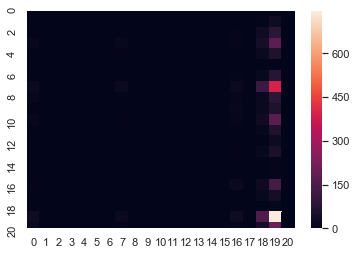

In [111]:
# Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(X_train, y_train)
accuracy = gnb.score(X_test, y_test) 
print('Gaussian Naive Bayes', accuracy)
gnb_preds = gnb.predict(X_test) 
cm = confusion_matrix(y_test, gnb_preds)
sns.heatmap(cm)

In [ ]:
gnb.predict_proba

In [129]:
# Gaussian Naive Bayes
knn_acc = []
for n_neighbors in range(1,151):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test) 
#     print(f'KNN {n_neighbors} accuracy = ', accuracy)
    knn_acc += [[n_neighbors, accuracy
                 

Text(0.5, 1.0, 'Time / DOW; Department Classifiers Only - KNN Neighbor Sizes vs. Accuracy')

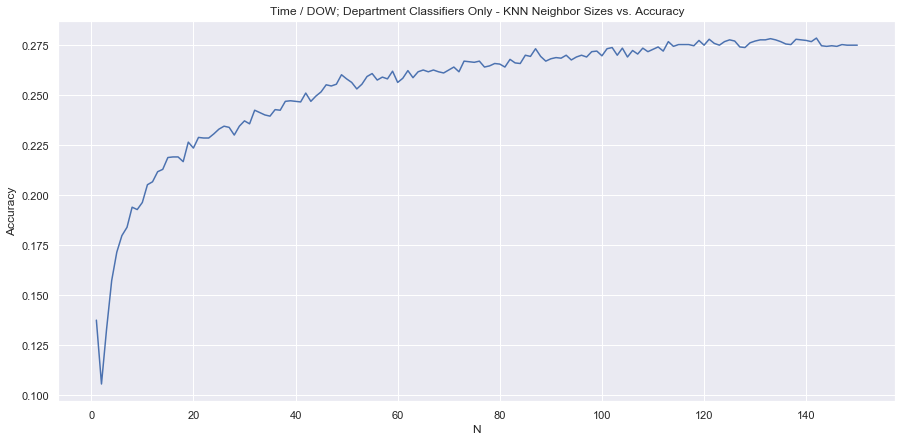

In [134]:
knn_acc = pd.DataFrame(data=knn_acc, columns=['N', 'Accuracy'])

fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x='N', y='Accuracy', data=knn_acc)
plt.title('Time / DOW; Department Classifiers Only - KNN Neighbor Sizes vs. Accuracy')

In [164]:
max_depth = 2
dtree_model = DecisionTreeClassifier(max_depth = max_depth)
dtree_model.fit(X_train, y_train) 
#     dtree_preds = dtree_model.predict(X_test)
accuracy = dtree_model.score(X_test, y_test) 
print(f'Decision Tree Accuracy, depth {max_depth}: ', accuracy)

Decision Tree Accuracy, depth 2:  0.28795038393384526


In [165]:
from sklearn import tree

In [166]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [167]:
dtree = dtree_model

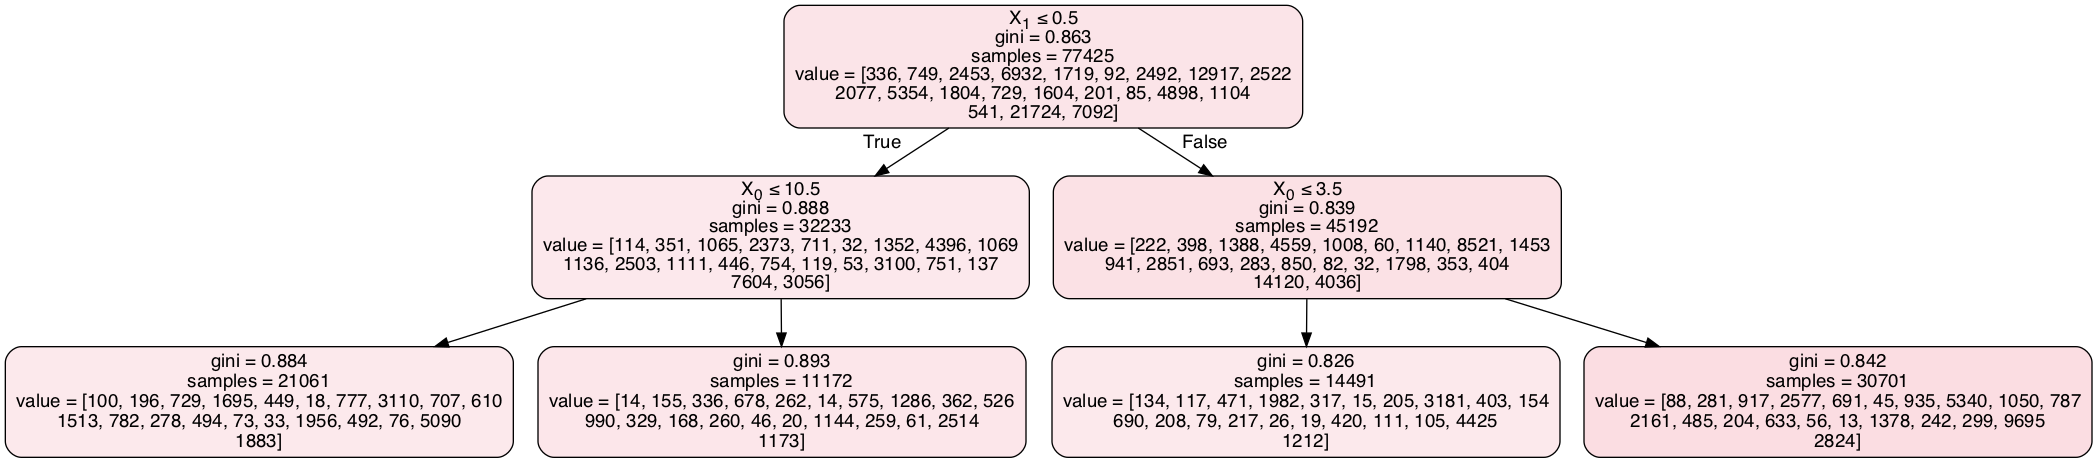

In [168]:
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# User Profiles

## Initialize User Dataframe

In [24]:
# Create a users database with some historical information for each user

df_user_profs = pd.DataFrame()
df_user_profs['user_id'] = user_subset
# df_user_profs.set_index('user_id', inplace=True)
df_user_profs.head(3)

,user_id
0,1
1,2
2,3


## Generate High-level User Features

### User Order History : `order_id_history` (User)

In [25]:
def query_user_order_history(user_id, df_orders_log):
    '''
    
    Return an ordered list of tuples,
    e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
    '''
    
    user_orders = df_orders_log[df_orders_log.user_id == user_id]
    
    return (user_orders[['order_number', 'order_id']]).to_numpy()
 

In [26]:
df_user_profs['order_id_history'] = df_user_profs.user_id.apply(
    query_user_order_history, df_orders_log=df_orders_log
)

In [27]:
df_user_profs.head(1)

,user_id,order_id_history
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ..."


### Unique Order Count (User)

In [28]:
df_user_profs['num_orders'] = df_user_profs.order_id_history.apply(lambda x: len(x))
df_user_profs.head(2)

,user_id,order_id_history,num_orders
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11
1,2,"[[1, 2168274], [2, 1501582], [3, 1901567], [4,...",15


### Order Sizes (User)

In [29]:
(df_order_prods__prior[df_order_prods__prior.order_id == 2539329]
                              .groupby('order_id')
).agg('nunique')['product_id']

order_id
2539329    5
Name: product_id, dtype: int64

In [30]:
## Average Order Sizes by User ##

run_limit = 5
run_count = 0

def avg_user_order_sizes(order_id_history, df_order_prods):
    
#     global run_count
#     global run_limit
    
#     run_count += 1
#     if run_count > run_limit:
#         return 0

    
#     print(order_id_history)
    order_id_list = order_id_history[:,1]
#     print(order_id_list)
#     print(type(order_id_list))

    avg_order_size = (
        df_order_prods[df_order_prods.order_id.isin(order_id_list)]              
        .groupby('order_id')
        .agg('nunique')
    ).mean()['product_id']

#     print(avg_order_size)
    return avg_order_size

df_user_profs['avg_order_size'] = (df_user_profs.order_id_history
                                    .apply(avg_user_order_sizes, df_order_prods=df_order_prods__prior)
                                   )

df_user_profs.head()

,user_id,order_id_history,num_orders,avg_order_size
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11,5.900000
1,2,"[[1, 2168274], [2, 1501582], [3, 1901567], [4,...",15,13.928571
2,3,"[[1, 1374495], [2, 444309], [3, 3002854], [4, ...",13,7.333333
3,4,"[[1, 3343014], [2, 2030307], [3, 691089], [4, ...",6,3.600000
4,5,"[[1, 2717275], [2, 1909121], [3, 2267326], [4,...",5,9.250000


### Department Affinity – Occurence (User)

Calculate support for the total products ordered from each department_id.

In [33]:
def order_department_visits(order_id)
    '''
    
    Given an order_id, look up the order,
    and calculate the total number of visits to each department.
    Return a vector the length of the number of departments.
    
    '''
    
    product_list

SyntaxError: invalid syntax (<ipython-input-33-9bcb8f1ca6d2>, line 1)

In [31]:
# Create a dictionary with department IDs as keys
# each value is the number of unique department check-ins.
# i.e. An order with two products from the same department
# should count as 1 unique check-in.

user_hist['dept_dict'] = dict(zip(depts.department_id.values,0*depts.department_id.values))

def department(user_id, orders, order_prods, subset='prior'):
    
    user_orders = orders[(orders.user_id == user_id) & (orders.eval_set == subset)]
    
    gb_order = user_orders.groupby('order_id')
    
    
    
    for group in gb_order:
        
        
    
    
    return order_sizes


user_hist['prior_order_sizes'] = pd.Series(user_hist.index.values).apply(
    order_sizes,
    orders=orders,
    order_prods=all_order_prods
)

IndentationError: expected an indented block (<ipython-input-31-22e956197d1d>, line 21)

# Department Profiles

In [455]:
# Create a department profile dataframe

df_dept_profs = pd.DataFrame()
df_dept_profs['department_id'] = df_dept_index.department_id

In [456]:
df_dept_profs.head(2)

,department_id
0,1
1,2


### Orders / Department

In [458]:
# Calculate number of orders in each department.
dept_nunique = df_order_prods.groupby('department_id').nunique()['order_id'].reset_index()
dept_nunique.rename(columns={'order_id':'num_orders'}, inplace=True)

df_dept_profs = pd.merge(df_dept_profs, dept_nunique, on='department_id')
df_dept_profs.head(3)
# df_user_profs.set_index('user_id', inplace=True)

,department_id,num_orders_x,num_orders_y
0,1,2779,2779
1,2,86,86
2,3,1996,1996
